In [1]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [67]:
import numpy as np 

class ExperienceReplayBuffer: 
    def __init__(self, max_memory, input_shape, n_actions): 
        self.mem_size = max_memory
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_experience(self, state, action, reward, next_state, done): 
        index = self.mem_counter % self.mem_size 

        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1
        

    def sample_experience(self, batch_size):
        max_mem = min(self.mem_counter, self.mem_size)
        batch_index = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch_index]
        next_states = self.new_state_memory[batch_index]
        rewards = self.reward_memory[batch_index]
        actions = self.action_memory[batch_index]
        terminal = self.terminal_memory[batch_index]

        return states, actions, rewards, next_states, terminal


In [68]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, Input


class DeepQNetwork2D(keras.Model):
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork2D, self).__init__()
     #   self.fc1 = Dense(64, activation='relu')
        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(n_actions, activation=None)

    def call(self, state):

        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class DeepQNetwork3D(keras.Model): 
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork3D, self).__init__()

        self.conv1 = Conv2D(32, 8, strides=(4, 4), activation='relu', data_format="channels_first")
        self.conv2 = Conv2D(32, 4, strides=(2, 2), activation='relu', data_format="channels_first")
        self.conv3 = Conv2D(64, 3, strides=(1, 1), activation='relu', data_format="channels_first")
        self.flatten = Flatten()

        self.fc2 = Dense(128, activation='relu')
        self.fc3 = Dense(n_actions, activation=None)

    def call(self, state):

        x = self.conv1(state)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [69]:
import numpy as np

def epsilon_greedy_policy(q_val_network, observation, action_space, epsilon):
        if np.random.random() > epsilon:
            state = tf.convert_to_tensor([observation])
            actions = q_val_network.predict(state, verbose=0)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(action_space)
        return action


def greedy_policy(observation, q_val_network, action_space): 
    state = tf.convert_to_tensor([observation])
    actions = q_val_network(state)
    action = tf.math.argmax(actions, axis=1).numpy()[0]
    return action


In [70]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

#https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/tf2/agent.py
class Agent: 
    def __init__(self, agent_params):
        # Parameters
        self.gamma = agent_params.get("gamma")
        self.lr = agent_params.get("lr")
        self.input_dims = agent_params.get("input_dims")
        self.batch_size = agent_params.get("batch_size")
        self.replace_target_weight_counter = agent_params.get("replace")
        self.algo = agent_params.get("algo")
        self.env_name = agent_params.get("env_name")
        self.chkpt_dir = agent_params.get("chkpt_dir")
        self.n_actions = agent_params.get("n_actions")
        self.action_space = agent_params.get('actions')
        
        self.eps = agent_params.get("eps")
        self.min_eps = agent_params.get("min_eps")
        self.eps_decay_rate = agent_params.get("eps_decay_rate")
        
        self.learn_step_counter = 0
        self.fname = self.chkpt_dir + self.env_name + '_' + self.algo + '_'
        self.mem_size = agent_params.get("mem_size")

        # networks and replaybuffer
        self.memory = ExperienceReplayBuffer(self.mem_size, self.input_dims, self.n_actions)
        self.q_value_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.q_value_network.compile(optimizer=Adam(learning_rate=self.lr))
        self.target_q_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.target_q_network.compile(optimizer=Adam(learning_rate=self.lr))

    def save_models(self):
        self.q_value_network.save(self.fname+'q_value')
        self.target_q_network.save(self.fname+'target_q')
        print('... models saved successfully ...')

    def load_models(self):
        self.q_value_network = keras.models.load_model(self.fname+'q_value')
        self.target_q_network = keras.models.load_model(self.fname+'target_q')
        print('... models loaded successfully ...')

    def store_experience(self, state, action, reward, state_, done):
        self.memory.store_experience(state, action, reward, state_, done)

    def sample_experience(self):
        state, action, reward, new_state, done = \
                                  self.memory.sample_experience(self.batch_size)
        states = tf.convert_to_tensor(state)
        rewards = tf.convert_to_tensor(reward)
        dones = tf.convert_to_tensor(done)
        actions = tf.convert_to_tensor(action, dtype=tf.int32)
        states_ = tf.convert_to_tensor(new_state)
        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.eps:
            state = tf.convert_to_tensor([observation])
            actions = self.q_value_network(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(self.action_space)
        return action

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_weight_counter == 0:
            self.target_q_network.set_weights(self.q_value_network.get_weights())
    
    def decrement_epsilon(self): 
        self.eps -= self.eps_decay_rate
        self.eps = max(self.eps, self.min_eps)

    def learn(self):
        if self.memory.mem_counter < self.batch_size:
            return

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_experience()

        indices = tf.range(self.batch_size, dtype=tf.int32)
      
        action_indices = tf.stack([indices, actions], axis=1)

        with tf.GradientTape() as tape:
            q_pred = tf.gather_nd(self.q_value_network(states), indices=action_indices)
            q_eval = self.target_q_network(states_)

            max_actions = tf.math.argmax(q_eval, axis=1, output_type=tf.int32)
            max_action_idx = tf.stack([indices, max_actions], axis=1)

            q_target = rewards + \
                self.gamma*tf.gather_nd(q_eval, indices=max_action_idx) *\
                (1 - dones.numpy())

            loss = keras.losses.MSE(q_pred, q_target)

        params = self.q_value_network.trainable_variables
        grads = tape.gradient(loss, params)

        self.q_value_network.optimizer.apply_gradients(zip(grads, params))

        self.learn_step_counter += 1
        
        self.decrement_epsilon()
        
        return self.eps

In [71]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [72]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [73]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)


In [74]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [75]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, trainer_params): 
       
        self.env = env 
        self.noe = trainer_params.get("noe")
        self.max_steps = trainer_params.get("max_steps")
       
        self.eps_decay_rate = trainer_params.get("eps_decay_rate")
        self.action_space = trainer_params.get("action_space")
        self.is_tg = trainer_params.get("is_tg")
        self.tg_bot_freq_epi = trainer_params.get("tg_bot_freq_epi")
        self.record = trainer_params.get("record")
        self.agent_params = {
                        "gamma":  trainer_params.get("gamma"), 
                        "lr":  trainer_params.get("lr"), 
                        "input_dims":  trainer_params.get("input_dims"),
                        "mem_size" :  trainer_params.get("mem_size"),
                        "batch_size" :  trainer_params.get("batch_size"),
                        "replace" :  trainer_params.get("replace"),
                        "algo" :  trainer_params.get("algo"),
                        "env_name" :  trainer_params.get("env_name"),
                        "n_actions" :  trainer_params.get("n_actions"),
                        "chkpt_dir":  trainer_params.get("chkpt_dir"),
                        "actions":  trainer_params.get("actions"),
                        "eps": trainer_params.get("eps"),
                        "min_eps": trainer_params.get("min_eps"),
                        "eps_decay_rate": trainer_params.get("eps_decay_rate")
                    }
        
        self.agent = Agent(self.agent_params)
        
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo("dqn", "videos/", 20)
        
        self.target_score = trainer_params.get("target_score")

    def train_rl_model(self): 
        episode_rewards = []
        epsilon_history = []
        avg_rewards = []
        best_reward = float("-inf")

        for episode in range(self.noe): 
            n_steps = 0 
            episodic_loss = 0
            state = self.env.reset()
            reward = 0 
            
            if self.record and episode%100==0: 
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 
                
                if self.record and episode%100==0: 
                    img = self.env.render()
                    self.recorder.add_image(img)

                if type(state) == tuple: 
                    state = state[0]
                state = state

                action = self.agent.choose_action(state)

                next_info = self.env.step(action)
                next_state, reward_prob, terminated, truncated, _ = next_info
                done = truncated or terminated
                reward += reward_prob

                self.agent.store_experience(state, action, reward_prob, next_state, done)
                eps = self.agent.learn()

                state = next_state
                n_steps += 1 
               
                
                if done: 
                    break

            epsilon_history.append(eps)
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

            result = f"Episode: {episode}, Epsilon: {eps}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            print(result)
            
            # Saving Best Model
            if reward > best_reward: 
                best_reward = reward
                self.agent.save_models()
            
            # video Recorder
            if episode % 100 ==0:
                self.recorder.save(episode)
                
          # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
         # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-100:]) >= self.target_score: 
                break
                
                
        return episode_rewards, epsilon_history, avg_rewards, best_reward

In [ ]:
import gymnasium as gym
import time

env = make_env("ALE/Pong-v5", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]

episodic_rewards_filename = 'array_files/episodic_reward.npy'
epsilon_history_filename = 'array_files/epsilon_history.npy'
cum_avg_reward_filename = 'array_files/cum_avg_rewards.npy'
losses_filename = 'array_files/losses.npy'

agent_params = {
    "gamma": 0.99, 
    "lr": 0.001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 20000,
    "batch_size" : 32,
    "replace" : 1000,
    "algo" : "DQN",
    "env_name" : "pong-v5",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dqn/",
    "actions": action_space
}

trainer_params = {
    "noe": 50, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.02,
    "eps_decay_rate": 1e-4,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    
}

if __name__ == "__main__": 
    try: 
        manage_memory()
        
        trainer = Trainer(agent, env, trainer_params)

        episode_rewards, avg_rewards, best_reward = trainer.train_rl_model()
    #    plot_learning_curve(episode_rewards, "plot_file")

       # eval_model(env, "keras model", "videos/", fps=10)
    
    except Exception as error:
        raise error


Episode: 0, Epsilon: 0.9993900000000028, Steps: 92, Reward: -137.38510392355738, Best reward: -inf, Avg reward: -137.38510392355738
... models saved successfully ...


[swscaler @ 0x6e95600] Warning: data is not aligned! This can lead to a speed loss


Episode: 1, Epsilon: 0.9981200000000086, Steps: 127, Reward: -213.78064784841425, Best reward: -137.38510392355738, Avg reward: -175.5828758859858
Episode: 2, Epsilon: 0.9974400000000117, Steps: 68, Reward: -144.77086232872736, Best reward: -137.38510392355738, Avg reward: -165.312204700233
Episode: 3, Epsilon: 0.9966100000000154, Steps: 83, Reward: -76.86136828083374, Best reward: -137.38510392355738, Avg reward: -143.19949559538318
... models saved successfully ...
Episode: 4, Epsilon: 0.9955100000000204, Steps: 110, Reward: -206.30120982040685, Best reward: -76.86136828083374, Avg reward: -155.8198384403879
Episode: 5, Epsilon: 0.9948200000000236, Steps: 69, Reward: -74.98256866458331, Best reward: -76.86136828083374, Avg reward: -142.34696014442048
... models saved successfully ...
Episode: 6, Epsilon: 0.9941400000000267, Steps: 68, Reward: -191.3295853598421, Best reward: -74.98256866458331, Avg reward: -149.34447803233783
Episode: 7, Epsilon: 0.9932200000000309, Steps: 92, Reward

[swscaler @ 0x5ec8600] Warning: data is not aligned! This can lead to a speed loss


Episode: 101, Epsilon: 0.9043300000004354, Steps: 68, Reward: -77.81923923097354, Best reward: -42.86532258057393, Avg reward: -172.7563303888911
Episode: 102, Epsilon: 0.9034200000004395, Steps: 91, Reward: -85.68118856296584, Best reward: -42.86532258057393, Avg reward: -172.16543365123346
Episode: 103, Epsilon: 0.9021500000004453, Steps: 127, Reward: -125.51304888229132, Best reward: -42.86532258057393, Avg reward: -172.65195045724806
Episode: 104, Epsilon: 0.90111000000045, Steps: 104, Reward: -109.10971353070322, Best reward: -42.86532258057393, Avg reward: -171.680035494351
Episode: 105, Epsilon: 0.9001600000004544, Steps: 95, Reward: -291.3458793794283, Best reward: -42.86532258057393, Avg reward: -173.84366860149947
Episode: 106, Epsilon: 0.8993500000004581, Steps: 81, Reward: -283.0143356611499, Best reward: -42.86532258057393, Avg reward: -174.76051610451256
Episode: 107, Epsilon: 0.8980000000004642, Steps: 135, Reward: -109.42609244009691, Best reward: -42.86532258057393, Av

[swscaler @ 0x5670600] Warning: data is not aligned! This can lead to a speed loss


Episode: 201, Epsilon: 0.8018900000009016, Steps: 99, Reward: -97.93528205023969, Best reward: 19.721869131988143, Avg reward: -144.1937489442673
Episode: 202, Epsilon: 0.800700000000907, Steps: 119, Reward: -10.155711453493865, Best reward: 19.721869131988143, Avg reward: -143.43849417317256
Episode: 203, Epsilon: 0.7992500000009136, Steps: 145, Reward: -73.22668612996432, Best reward: 19.721869131988143, Avg reward: -142.9156305456493
Episode: 204, Epsilon: 0.798510000000917, Steps: 74, Reward: -104.93162632468423, Best reward: 19.721869131988143, Avg reward: -142.8738496735891
Episode: 205, Epsilon: 0.7976900000009207, Steps: 82, Reward: -110.66108374954386, Best reward: 19.721869131988143, Avg reward: -141.06700171729025
Episode: 206, Epsilon: 0.7968900000009244, Steps: 80, Reward: -120.03472358711025, Best reward: 19.721869131988143, Avg reward: -139.43720559654986
Episode: 207, Epsilon: 0.795870000000929, Steps: 102, Reward: -61.31706139531637, Best reward: 19.721869131988143, Av

[swscaler @ 0x6882600] Warning: data is not aligned! This can lead to a speed loss


Episode: 301, Epsilon: 0.6746000000014809, Steps: 119, Reward: -72.83302458650822, Best reward: 48.92899544848648, Avg reward: -99.42149473282392
Episode: 302, Epsilon: 0.673700000001485, Steps: 90, Reward: -90.64343767564142, Best reward: 48.92899544848648, Avg reward: -100.2263719950454
Episode: 303, Epsilon: 0.6723400000014912, Steps: 136, Reward: 0.8572069134395264, Best reward: 48.92899544848648, Avg reward: -99.48553306461136
Episode: 304, Epsilon: 0.6708300000014981, Steps: 151, Reward: -45.48953317433143, Best reward: 48.92899544848648, Avg reward: -98.89111213310784
Episode: 305, Epsilon: 0.6696900000015032, Steps: 114, Reward: -85.42438542960686, Best reward: 48.92899544848648, Avg reward: -98.63874514990846
Episode: 306, Epsilon: 0.6683900000015092, Steps: 130, Reward: -11.117786674627936, Best reward: 48.92899544848648, Avg reward: -97.54957578078366
Episode: 307, Epsilon: 0.6583900000015547, Steps: 1000, Reward: 24.859187378867237, Best reward: 48.92899544848648, Avg rewar

[swscaler @ 0x66ea600] Warning: data is not aligned! This can lead to a speed loss


Episode: 401, Epsilon: 0.47724000000225275, Steps: 117, Reward: -71.78214218758883, Best reward: 62.66157820076207, Avg reward: -68.92263543949831
Episode: 402, Epsilon: 0.47455000000225006, Steps: 269, Reward: 22.301321884303107, Best reward: 62.66157820076207, Avg reward: -67.79318784389886
Episode: 403, Epsilon: 0.4656800000022412, Steps: 887, Reward: -192.37956739364813, Best reward: 62.66157820076207, Avg reward: -69.72555558696975
Episode: 404, Epsilon: 0.46213000000223764, Steps: 355, Reward: -93.66643472356783, Best reward: 62.66157820076207, Avg reward: -70.20732460246211
Episode: 405, Epsilon: 0.45213000000222764, Steps: 1000, Reward: -12.71656766689383, Best reward: 62.66157820076207, Avg reward: -69.48024642483497
Episode: 406, Epsilon: 0.44213000000221764, Steps: 1000, Reward: -40.80028690074558, Best reward: 62.66157820076207, Avg reward: -69.77707142709617
Episode: 407, Epsilon: 0.43213000000220764, Steps: 1000, Reward: -16.50542054400888, Best reward: 62.66157820076207,

[swscaler @ 0x6fe2200] Warning: data is not aligned! This can lead to a speed loss


Episode: 501, Epsilon: 0.1, Steps: 1000, Reward: -53.15268196220725, Best reward: 196.5069985065738, Avg reward: -8.559290584929917
Episode: 502, Epsilon: 0.1, Steps: 1000, Reward: 57.2794195579082, Best reward: 196.5069985065738, Avg reward: -8.209509608193866
Episode: 503, Epsilon: 0.1, Steps: 504, Reward: 231.82639125430833, Best reward: 196.5069985065738, Avg reward: -3.967450021714302
... models saved successfully ...
Episode: 504, Epsilon: 0.1, Steps: 1000, Reward: 35.343285236345366, Best reward: 231.82639125430833, Avg reward: -2.67735282211517
Episode: 505, Epsilon: 0.1, Steps: 1000, Reward: 15.163923675041964, Best reward: 231.82639125430833, Avg reward: -2.398547908695812
Episode: 506, Epsilon: 0.1, Steps: 1000, Reward: -37.14115493462857, Best reward: 231.82639125430833, Avg reward: -2.361956589034642
Episode: 507, Epsilon: 0.1, Steps: 1000, Reward: -48.87642837777034, Best reward: 231.82639125430833, Avg reward: -2.6856666673722573
Episode: 508, Epsilon: 0.1, Steps: 1000, 

[swscaler @ 0x6390200] Warning: data is not aligned! This can lead to a speed loss


Episode: 601, Epsilon: 0.1, Steps: 1000, Reward: -175.5880237788458, Best reward: 289.3226464753144, Avg reward: 35.64685654198219
Episode: 602, Epsilon: 0.1, Steps: 602, Reward: 111.58180279534412, Best reward: 289.3226464753144, Avg reward: 36.18988037435655
Episode: 603, Epsilon: 0.1, Steps: 391, Reward: 220.58907033478425, Best reward: 289.3226464753144, Avg reward: 36.07750716516131
Episode: 604, Epsilon: 0.1, Steps: 589, Reward: 264.1007613002837, Best reward: 289.3226464753144, Avg reward: 38.36508192580069
Episode: 605, Epsilon: 0.1, Steps: 954, Reward: -193.77920607160277, Best reward: 289.3226464753144, Avg reward: 36.27565062833424
Episode: 606, Epsilon: 0.1, Steps: 283, Reward: -59.10444555260936, Best reward: 289.3226464753144, Avg reward: 36.05601772215444
Episode: 607, Epsilon: 0.1, Steps: 967, Reward: 140.48455598319208, Best reward: 289.3226464753144, Avg reward: 37.94962756576406
Episode: 608, Epsilon: 0.1, Steps: 953, Reward: 132.0523405688353, Best reward: 289.32264

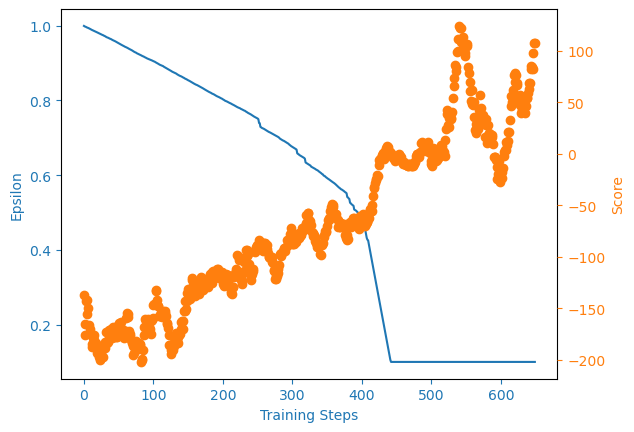

In [33]:
import gymnasium as gym
import time
import signal
import time
import sys
import pickle

env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
record = True


trainer_params = {
    "noe": 650, 
    "max_steps": 1000,
    "max_eps": 1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-5,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.99, 
    "lr": 0.0001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 20000,
    "batch_size" : 32,
    "replace" : 1000,
    "algo" : "DQN",
    "env_name" : "lunarlander",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dqn/",
    "actions": action_space,
    "target_score": 230
}

    
if __name__ == "__main__": 
    
    try: 
        manage_memory()
       
        trainer = Trainer(env, trainer_params)
        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("dqn_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("dqn_epsilon_history.obj", "wb") as f: 
            pickle.dump(epsilon_history, f)
        
        with open("dqn_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        plot_learning_curve(episode_rewards, epsilon_history, "plot_file")
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)


In [49]:
import random 
import imageio
import tensorflow as tf 


class Eval: 

    def __init__(self, env, model_path, action_space, number_of_episode=50, test_video_path="test_videos/"):
        self.env = env 
        self.model = tf.keras.models.load_model(model_path)
        self.recorder = RecordVideo('dqn_lunarlander_test', test_video_path, 15)
        self.number_of_episode = number_of_episode
        self.action_space = action_space
        
    def test(self): 
        rewards = []
        steps = []
        for episode in range(self.number_of_episode): 
            done = False
            reward = 0
            step = 0
            state = env.reset(seed=random.randint(0,500))
            if episode % 5 == 0: 
                img = env.render()
                self.recorder.add_image(img) 

            while not done:
                if type(state) == tuple: 
                    state = state[0]
                    
                action =  greedy_policy(state, self.model, self.action_space)
                state, reward_prob, terminated, truncated, _ = env.step(action)
                done = terminated or truncated 
                reward += reward_prob
                step += 1 
                if episode % 10 == 0:
                    img = env.render()
                    self.recorder.add_image(img)
            
            rewards.append(reward)
            steps.append(step)
            self.recorder.save(1) if episode % 5 == 0 else None
        
        return rewards, steps                                                                                                                                                        


In [50]:
env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
model_path = "/kaggle/working/tmp/dqn/lunarlander_DQN_q_value/"

eval = Eval(env, model_path, action_space, 1)

In [64]:
test_rewards, steps = eval.test()

[swscaler @ 0x5793600] Warning: data is not aligned! This can lead to a speed loss


In [65]:
test_rewards

[260.1516958298929]